## Importing basic libraries for plots and matrix calculations

In [9]:
import numpy as np
import pandas as pd
import random
import os
import math
import pickle
import matplotlib.pyplot as plt

## Reading both feature and label text files and saving into dataframe and viewing first five records

In [10]:
data_img = pd.read_csv('MNISTnumImages5000.txt',sep="\t", header=None)

In [11]:
data_lbl = pd.read_csv('MNISTnumLabels5000.txt', sep="\t", header=None)

In [173]:
data_img.head()

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0.0,...,0.0,0.0,0,0,0,0,0,0,0,0


In [13]:
data_lbl.head()

,0
0,7
1,2
2,1
3,0
4,4


## Distribution of records digit wise

In [14]:
data_lbl.iloc[:,0].value_counts()

1    571
2    530
9    520
7    512
3    500
4    500
8    489
6    462
0    460
5    456
Name: 0, dtype: int64

## Function to change target to 1,0 representation

In [15]:
def bin_encode(target):
    arr_target = np.zeros((10, 1))
    a=[]
    for i in range(10):
        if i==target:
            a.append([1.])
        else:
            a.append([0.])
    arr_target=np.array(a)
    return arr_target

## Activations functions and their derivative functions

In [16]:
def act_sig(u):
    v = 1.0 / (1.0 + np.exp(-u))
    return v

def act_sig_deri(u):
    v= act_sig(u) * (1 - act_sig(u))
    return v

def act_relu(u):
    v=np.maximum(u,0)
    return v

def act_relu_deri(u):
    u[u<=0]=0
    u[u>0]=1
    return u

def act_tanh(u,a,b):
    v = a * np.tanh(b * u)
    return v

def act_tanh_deri(u,a,b):
    v= (b/a) * ((a*a) - (u * u)) 
    return v

def get_act(act_fun,u):
    if act_fun=="sigmoid":
        return act_sig(u)
    elif act_fun=="relu":
        return act_relu(u)
    elif act_fun=="tanh":
        a=1.7159
        b=2/3
        return act_tanh(u,a,b)
    else:
        raise ValueError('Activation function not found')
        
def get_act_derv(act_fun,u):
    if act_fun=="sigmoid":
        return act_sig_deri(u)
    elif act_fun=="relu":
        return act_relu_deri(u)
    elif act_fun=="tanh":
        a=1.7159
        b=2/3
        return act_tanh_deri(u,a,b)
    else:
        raise ValueError('Activation function not found')
    

## Multi layer Feed forward network implementation(Setting weights from input to first hidden layer to defaults weights by passing as parameter and not updating them in backpropogation) with following parameters as inputs :
saved_Weig :- To pass different weights to get network A and network B config.
saved_B :-    To pass different biases to get network A and network B config.
layers_list :- list containing input neurons , hidden layers neurons , output layer neurons in same order.
activations :- list containing corresponding activation functions (sigmoid, relu ,tanh) first element of list can be anything as                inputs will be first activations and so no need of activation function.
lr          :- learning rate
momentum    :- momentum
iters       :- epochs
bat_size    :- batch size for Stochaistic Gradient Descent
auto        :- flag to run second ques as it involves calculating cost function which is not needed for ques 1 in HW3

In [1]:
class Model(object):

    def __init__(self, saved_Weig, saved_B, layer_list=list(),act_list=list(), lr=1.0,momentum=0.1,iters=10, bat_size=16, auto=False):
        
        self.eta = lr
        self.momentum = momentum
        self.iters = iters
        self.bat_size = bat_size
        self.auto=auto
        self.layer_list = layer_list
        self.layers_len = len(layer_list)
        self.act_list=act_list
        self.act_len = len(act_list)
        if self.layers_len != self.act_len:
            raise ValueError('Activations and Layers size should match')
            
        self.W=[]
        self.W.append(np.array([0]))
        
        for i in range(1,len(layer_list)):
            a=math.sqrt(6/layer_list[i-1])
            tmp=np.zeros((layer_list[i],layer_list[i-1]))
            for j in range(layer_list[i]):
                tmp[j]=np.random.uniform(-a, a, layer_list[i-1])
            self.W.append(tmp)
            
        self.B = [np.zeros((i,1)) for i in layer_list]
        self.S = [np.zeros((i,1)) for i in layer_list]
        self.A = [np.zeros((i,1)) for i in layer_list]
        
        
        #########code changes to set weights from input to hidden using passed weights########
        self.W[1]=np.copy(saved_Weig[1])
        self.B[1]=np.copy(saved_B[1])
    
        if self.auto:
            self.store("auto-intial-"+str(self.layer_list[1])+".pkl")
        else:
            self.store("model-intial-"+str(self.layer_list[1])+".pkl")
        
       

    def train(self, dt_train, dt_val, dt_test, auto):
        
        flag=0
        thr=[]
        vhr=[]
        tehr=[]
        
        tc=[]
        vc=[]
        tec=[]
        
        if auto:
            train_cost = (self.getError(dt_train))
            val_cost = (self.getError(dt_val))
            test_cost =(self.getError(dt_test))
            tc.append(train_cost)
            vc.append(val_cost)
            tec.append(test_cost)
            print("For epoch {0}, validating error {1} , training error {2} , testing error {3}.".format(0,val_cost,train_cost,test_cost))
        else:
            train_hit_rate = (self.validateTrain(dt_train)) / (len(dt_train))
            val_hit_rate = (self.validate(dt_val)) / (len(dt_val))
            test_hit_rate =(self.validate(dt_test)) / (len(dt_test))
            thr.append(train_hit_rate)
            vhr.append(val_hit_rate)
            tehr.append(test_hit_rate)
            print("For epoch {0}, validating hit rate {1} , training hit rate {2} , testing hit rate {3}.".format(0,val_hit_rate,train_hit_rate,test_hit_rate))
         
        
        for itr in range(self.iters):
            random.shuffle(dt_train)
            train_subsets=[]
            for i in range(0, len(dt_train), self.bat_size):
                train_subsets.append(dt_train[i:i + self.bat_size])
            
            main_delta_b= [np.zeros(b.shape) for b in self.B]
            main_delta_w= [np.zeros(w.shape) for w in self.W]
            for dt_train_batch in train_subsets:
                delta_b = [np.zeros(b.shape) for b in self.B]
                delta_w = [np.zeros(w.shape) for w in self.W]

                for features, targets in dt_train_batch:
                    self.FP(features)
                    tmp_delta_b, tmp_delta_w = self.BP(targets)
                    delta_b = [db + tdb  for db, tdb in zip(delta_b, tmp_delta_b)]
                    delta_w = [dw + tdw  for dw, tdw in zip(delta_w, tmp_delta_w)]
                
                prev_delta_b = main_delta_b
                prev_delta_w = main_delta_w
                main_delta_w = [((self.eta / self.bat_size )* del_w) + (self.momentum * p_d_w) for del_w,p_d_w in zip (delta_w,prev_delta_w)] 
                main_delta_b = [((self.eta / self.bat_size )* del_b) + (self.momentum * p_d_b) for del_b,p_d_b in zip (delta_b,prev_delta_b)]
                
                self.updateWeights(main_delta_w, main_delta_b)
                #self.store("model-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[1])+str(itr+1)+".pkl")

            if not (itr+1) % 10:
                if auto:
                    train_cost = (self.getError(dt_train))
                    val_cost = (self.getError(dt_val))
                    test_cost =(self.getError(dt_test))
                    tc.append(train_cost)
                    vc.append(val_cost)
                    tec.append(test_cost)
                    print("For epoch {0}, validating error {1} , training error {2} , testing error {3}.".format(itr + 1,val_cost,train_cost,test_cost))
                    if len(vc)>3:
                        if ((vc[-1]>vc[-2] and vc[-1] > vc[-3] and vc[-1] > vc[-4]) or (vc[-1] ==vc[-2] and vc[-1] ==vc[-2] and vc[-1] ==vc[-3])):
                            flag=1
                else:
                    train_hit_rate = (self.validateTrain(dt_train)) / (len(dt_train))
                    val_hit_rate = (self.validate(dt_val)) / (len(dt_val))
                    test_hit_rate =(self.validate(dt_test)) / (len(dt_test))
                    thr.append(train_hit_rate)
                    vhr.append(val_hit_rate)
                    tehr.append(test_hit_rate)
                    print("For epoch {0}, validating hit rate {1} , training hit rate {2} , testing hit rate {3}.".format(itr + 1,val_hit_rate,train_hit_rate,test_hit_rate))
                    if len(vhr)>3:
                        if ((vhr[-1]<vhr[-2] and vhr[-1] < vhr[-3] and vhr[-1] < vhr[-4]) or (vhr[-1] ==vhr[-2] and vhr[-1] ==vhr[-2] and vhr[-1] ==vhr[-3])):
                            flag=1
            #comment below code flag=0 to run with stopping rule
            flag=0;
            if flag==1:
                if auto:
                    self.store("auto-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                else:
                    self.store("model-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                break
                
            if not (itr+1) % 30:
                if auto:
                    self.store("auto-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                else:
                    self.store("model-"+str(self.eta)+"-"+str(self.momentum)+str(self.act_list[-2])+'-'+str(self.act_list[-1])+str(itr+1)+".pkl")
                    
        return {'thr':thr,'vhr':vhr,'tehr':tehr,'vc':vc,'tc':tc,'tec':tec}
                
    def getError(self,dt):
        mainCost=0
        for feat, targ in dt:
            pred=self.test_auto(feat)
            err=targ-pred
            sqEr=err  * err
            tmpCost=(1/2) * np.sum(sqEr)
            mainCost=mainCost+tmpCost
        return mainCost
    
    def updateWeights(self, main_delta_w, main_delta_b):
        tmp_W = [w + delw for w, delw  in zip(self.W, main_delta_w)]
        tmp_B = [b + delb for b, delb in zip(self.B, main_delta_b)]
        self.W[1]=np.copy(tmp_W[1])
        self.B[1]=np.copy(tmp_B[1])

        
    
    def validate(self, dt_val):
        corr_points=0
        for feat, targ in dt_val:
            if self.test(feat) == targ:
                corr_points=corr_points+1
        return corr_points
    
    def validateTrain(self, dt_val):
        ft = []
        lb=  []
        for i, j in dt_val:
            ft.append(i)
            lb.append(np.argmax(j))
        dt=list(zip(ft,lb))
        corr_points=0
        for feat, targ in dt:
            if self.test(feat) == targ:
                corr_points=corr_points+1
        return corr_points

    def test(self, features):
        self.FP(features)
        return np.argmax(self.A[-1])
    
    def test_auto(self, features):
        self.FP(features)
        return self.A[-1]

    def FP(self, features):
        self.A[0] = features
        for i in range(1, self.layers_len):
            self.S[i] = (self.W[i].dot(self.A[i - 1]) + self.B[i])
            self.A[i] = get_act(self.act_list[i],self.S[i])
            
    def BP(self, target):
        delta_b = [np.zeros(b.shape) for b in self.B]
        delta_w = [np.zeros(w.shape) for w in self.W]
        #delta for output layer
        tmp_del = (target-self.A[-1]) * get_act_derv(self.act_list[-1],self.S[-1])
        delta_b[-1] = tmp_del
        delta_w[-1] = tmp_del.dot(self.A[-2].transpose())
        #delta for hidden layes
        for l in range(self.layers_len - 2, 0, -1):
            tmp_del = np.multiply(self.W[l + 1].transpose().dot(tmp_del),get_act_derv(self.act_list[l],self.S[l]))
            delta_b[l] = tmp_del
            delta_w[l] = tmp_del.dot(self.A[l - 1].transpose())
        return delta_b, delta_w

    def store(self, file='weights.pkl'):
        
        lr=self.eta 
        mm=self.momentum 
        iters=self.iters 
        bs=self.bat_size
        
        ll=self.layer_list 
        al=self.act_list
        
        W=self.W
        B=self.B
        
        dict={'lr':lr,'mm':mm,'iters':iters,'bs':bs,'ll':ll,'al':al,'W':W,'B':B}
        with open(os.path.join(os.curdir, file), 'wb') as f: 
            pickle.dump(dict, f)
        
    def load(self,saved_weights,saved_bias, epoch, lr,mm, file='weights.pkl', actFun_list=['NR','sigmoid','sigmoid']):
       
        with open(os.path.join(os.curdir, file),'rb') as f:  
            objb= pickle.load(f)
        self.eta=lr 
        self.momentum=mm
        self.iters = epoch
        self.bat_size=int(objb['bs'])
        self.act_list=actFun_list
        self.act_len = len(self.act_list)
        self.W = list(objb['W'])
        self.B = list(objb['B'])
        self.W[1] = saved_weights[1]
        self.B[1] = saved_bias[1]
        
        self.layer_list = [b.shape[0] for b in self.B]
        self.layers_len = len(self.layer_list)
        self.S = [np.zeros(b.shape) for b in self.B]
        self.A = [np.zeros(b.shape) for b in self.B]

## Splitting Data into train and test and viewing corresponding digit distribution

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data_img, data_lbl, test_size=0.2, random_state=0 , stratify=data_lbl)

In [19]:
Y_train.iloc[:,0].value_counts()

1    457
2    424
9    416
7    409
3    400
4    400
8    391
6    370
0    368
5    365
Name: 0, dtype: int64

In [20]:
Y_test.iloc[:,0].value_counts()

1    114
2    106
9    104
7    103
4    100
3    100
8     98
6     92
0     92
5     91
Name: 0, dtype: int64

## splitting train into train_new and validation dataset with 3500 points as train_new and 500 as validation set

In [21]:
X_train_new, X_valid, Y_train_new, Y_valid = train_test_split(X_train, Y_train, test_size=0.125, random_state=0 , stratify=Y_train)

In [22]:
Y_train_new.iloc[:,0].value_counts()

1    400
2    371
9    364
7    358
3    350
4    350
8    342
6    324
0    322
5    319
Name: 0, dtype: int64

In [23]:
Y_valid.iloc[:,0].value_counts()

1    57
2    53
9    52
7    51
4    50
3    50
8    49
6    46
5    46
0    46
Name: 0, dtype: int64

## Changing input and output into 2d array

In [24]:
arr_x_train = [np.reshape(X_train_new.iloc[i,:].tolist(), (len(X_train_new.columns), 1)) for i in range(len(X_train_new))]
arr_y_train = [bin_encode(y) for y in Y_train_new.iloc[:,0].tolist()]
data_train = list(zip(arr_x_train, arr_y_train))

In [25]:
arr_x_val = [np.reshape(X_valid.iloc[i,:].tolist(), (len(X_valid.columns), 1)) for i in range(len(X_valid))]
arr_y_val = Y_valid.iloc[:,0].tolist()
data_val = list(zip(arr_x_val, arr_y_val))

In [26]:
arr_x_test = [np.reshape(X_test.iloc[i,:].tolist(), (len(X_test.columns), 1)) for i in range(len(X_test))]
arr_y_test = Y_test.iloc[:,0].tolist()
data_test = list(zip(arr_x_test, arr_y_test))

## Preparing data for auto encoder where target variables will be same as input

In [27]:
arr_x_train_auto = [np.reshape(X_train_new.iloc[i,:].tolist(), (len(X_train_new.columns), 1)) for i in range(len(X_train_new))]
data_train_auto = list(zip(arr_x_train_auto, arr_x_train_auto))

In [28]:
arr_x_val_auto = [np.reshape(X_valid.iloc[i,:].tolist(), (len(X_valid.columns), 1)) for i in range(len(X_valid))]
data_val_auto = list(zip(arr_x_val_auto, arr_x_val_auto))

In [29]:
arr_x_test_auto = [np.reshape(X_test.iloc[i,:].tolist(), (len(X_test.columns), 1)) for i in range(len(X_test))]
data_test_auto = list(zip(arr_x_test_auto, arr_x_test_auto))

## START :code required for home work 4 problem -2

## Getting weights that are obtained  from HW3-PB2 autoencoder network to pass to NETWORK A

In [30]:
with open(os.path.join(os.curdir, 'auto-0.1-0.7relu-sigmoid330_PROBLEM2HW3.pkl'),'rb') as f:
    objb1= pickle.load(f)
weigToset = list(objb1['W'])
biasToset = list(objb1['B'])
weigToset[1]

array([[ 0.0777415 , -0.07881265, -0.02313645, ..., -0.0219766 ,
         0.04150438,  0.04457017],
       [ 0.01192869, -0.08542999,  0.02896431, ..., -0.08382999,
         0.06259795, -0.04928928],
       [ 0.02955516, -0.01916236,  0.06518259, ..., -0.00898574,
         0.00903259, -0.00374908],
       ...,
       [-0.07788886,  0.02893515,  0.08732697, ..., -0.08680339,
         0.06540784, -0.07005058],
       [ 0.07485286, -0.00591411, -0.06337624, ...,  0.0713778 ,
         0.05632839,  0.06079011],
       [-0.05187875,  0.06857552,  0.08085828, ..., -0.01304535,
        -0.00152263, -0.03486313]])

## Start :Experimenting with different hyper parameters

In [54]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','relu','relu']
momentum = 0.7
lr = 0.01
itrs = 30
batch_size = 32

nn = Model(weigToset,biasToset,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
spl_Run1=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.07 , training hit rate 0.084 , testing hit rate 0.102.
For epoch 10, validating hit rate 0.096 , training hit rate 0.09428571428571429 , testing hit rate 0.093.
For epoch 20, validating hit rate 0.096 , training hit rate 0.09457142857142857 , testing hit rate 0.096.
For epoch 30, validating hit rate 0.096 , training hit rate 0.09485714285714286 , testing hit rate 0.096.


In [57]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','relu','relu']
momentum = 0.3
lr = 0.01
itrs = 30
batch_size = 32

nn = Model(weigToset,biasToset,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
spl_Run1=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.084 , training hit rate 0.08685714285714285 , testing hit rate 0.084.
For epoch 10, validating hit rate 0.104 , training hit rate 0.108 , testing hit rate 0.104.
For epoch 20, validating hit rate 0.146 , training hit rate 0.14285714285714285 , testing hit rate 0.136.
For epoch 30, validating hit rate 0.154 , training hit rate 0.15057142857142858 , testing hit rate 0.148.


In [56]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','relu','relu']
momentum = 0.9
lr = 0.01
itrs = 30
batch_size = 32

nn = Model(weigToset,biasToset,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
spl_Run1=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.114 , training hit rate 0.10485714285714286 , testing hit rate 0.115.
For epoch 10, validating hit rate 0.234 , training hit rate 0.2382857142857143 , testing hit rate 0.248.
For epoch 20, validating hit rate 0.264 , training hit rate 0.26485714285714285 , testing hit rate 0.269.
For epoch 30, validating hit rate 0.28 , training hit rate 0.28314285714285714 , testing hit rate 0.28.


In [55]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.7
lr = 0.01
itrs = 30
batch_size = 32

nn = Model(weigToset,biasToset,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
spl_Run1=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.098 , training hit rate 0.08971428571428572 , testing hit rate 0.098.
For epoch 10, validating hit rate 0.294 , training hit rate 0.29742857142857143 , testing hit rate 0.287.
For epoch 20, validating hit rate 0.418 , training hit rate 0.41942857142857143 , testing hit rate 0.422.
For epoch 30, validating hit rate 0.488 , training hit rate 0.488 , testing hit rate 0.501.


In [80]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.9
lr = 0.01
itrs = 500
batch_size = 32

nn = Model(weigToset,biasToset,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
run_QUES2HW3=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.098 , training hit rate 0.09771428571428571 , testing hit rate 0.098.
For epoch 10, validating hit rate 0.458 , training hit rate 0.4734285714285714 , testing hit rate 0.472.
For epoch 20, validating hit rate 0.606 , training hit rate 0.6262857142857143 , testing hit rate 0.628.
For epoch 30, validating hit rate 0.68 , training hit rate 0.706 , testing hit rate 0.698.
For epoch 40, validating hit rate 0.716 , training hit rate 0.748 , testing hit rate 0.741.
For epoch 50, validating hit rate 0.766 , training hit rate 0.7782857142857142 , testing hit rate 0.763.
For epoch 60, validating hit rate 0.782 , training hit rate 0.7951428571428572 , testing hit rate 0.783.
For epoch 70, validating hit rate 0.79 , training hit rate 0.8054285714285714 , testing hit rate 0.797.
For epoch 80, validating hit rate 0.798 , training hit rate 0.8188571428571428 , testing hit rate 0.807.
For epoch 90, validating hit rate 0.812 , training hit rate 0.8277142857142857 , te

In [84]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.9
lr = 0.01
itrs = 500
batch_size = 32

nn = Model(weigToset,biasToset,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
run_QUES2HW3=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.106 , training hit rate 0.106 , testing hit rate 0.106.
For epoch 10, validating hit rate 0.108 , training hit rate 0.11514285714285714 , testing hit rate 0.112.
For epoch 20, validating hit rate 0.398 , training hit rate 0.3922857142857143 , testing hit rate 0.404.
For epoch 30, validating hit rate 0.552 , training hit rate 0.5734285714285714 , testing hit rate 0.576.
For epoch 40, validating hit rate 0.638 , training hit rate 0.6554285714285715 , testing hit rate 0.663.
For epoch 50, validating hit rate 0.696 , training hit rate 0.7045714285714286 , testing hit rate 0.714.
For epoch 60, validating hit rate 0.734 , training hit rate 0.7328571428571429 , testing hit rate 0.74.
For epoch 70, validating hit rate 0.754 , training hit rate 0.7505714285714286 , testing hit rate 0.762.
For epoch 80, validating hit rate 0.774 , training hit rate 0.7697142857142857 , testing hit rate 0.775.
For epoch 90, validating hit rate 0.784 , training hit rate 0.7817142

In [122]:
run_QUES2HW3_BKP=run_QUES2HW3

In [123]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.9
lr = 0.01
itrs = 750
batch_size = 32

nn = Model(weigToset,biasToset,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
run_QUES2HW3=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.096 , training hit rate 0.08742857142857142 , testing hit rate 0.095.
For epoch 10, validating hit rate 0.314 , training hit rate 0.338 , testing hit rate 0.35.
For epoch 20, validating hit rate 0.534 , training hit rate 0.538 , testing hit rate 0.572.
For epoch 30, validating hit rate 0.612 , training hit rate 0.6368571428571429 , testing hit rate 0.648.
For epoch 40, validating hit rate 0.674 , training hit rate 0.6845714285714286 , testing hit rate 0.694.
For epoch 50, validating hit rate 0.724 , training hit rate 0.7257142857142858 , testing hit rate 0.716.
For epoch 60, validating hit rate 0.74 , training hit rate 0.752 , testing hit rate 0.754.
For epoch 70, validating hit rate 0.766 , training hit rate 0.7754285714285715 , testing hit rate 0.777.
For epoch 80, validating hit rate 0.766 , training hit rate 0.7877142857142857 , testing hit rate 0.791.
For epoch 90, validating hit rate 0.77 , training hit rate 0.7957142857142857 , testing hit rate

## End : Experimenting with different hypermeters

## Running final run for NETWORK A with fine tuned hypermeters for 1250 EPOCHS

In [149]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.9
lr = 0.01
itrs = 1250
batch_size = 32

nn = Model(weigToset,biasToset,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
run_QUES2HW3=nn.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.09 , training hit rate 0.08657142857142858 , testing hit rate 0.102.
For epoch 10, validating hit rate 0.52 , training hit rate 0.49342857142857144 , testing hit rate 0.498.
For epoch 20, validating hit rate 0.648 , training hit rate 0.6477142857142857 , testing hit rate 0.64.
For epoch 30, validating hit rate 0.69 , training hit rate 0.7045714285714286 , testing hit rate 0.696.
For epoch 40, validating hit rate 0.722 , training hit rate 0.7451428571428571 , testing hit rate 0.736.
For epoch 50, validating hit rate 0.746 , training hit rate 0.7737142857142857 , testing hit rate 0.776.
For epoch 60, validating hit rate 0.774 , training hit rate 0.7925714285714286 , testing hit rate 0.802.
For epoch 70, validating hit rate 0.792 , training hit rate 0.8114285714285714 , testing hit rate 0.814.
For epoch 80, validating hit rate 0.802 , training hit rate 0.8217142857142857 , testing hit rate 0.821.
For epoch 90, validating hit rate 0.806 , training hit rat

For epoch 790, validating hit rate 0.88 , training hit rate 0.9065714285714286 , testing hit rate 0.884.
For epoch 800, validating hit rate 0.88 , training hit rate 0.9071428571428571 , testing hit rate 0.885.
For epoch 810, validating hit rate 0.88 , training hit rate 0.9074285714285715 , testing hit rate 0.884.
For epoch 820, validating hit rate 0.88 , training hit rate 0.9074285714285715 , testing hit rate 0.884.
For epoch 830, validating hit rate 0.88 , training hit rate 0.9074285714285715 , testing hit rate 0.884.
For epoch 840, validating hit rate 0.88 , training hit rate 0.908 , testing hit rate 0.885.
For epoch 850, validating hit rate 0.88 , training hit rate 0.9085714285714286 , testing hit rate 0.885.
For epoch 860, validating hit rate 0.88 , training hit rate 0.9088571428571428 , testing hit rate 0.885.
For epoch 870, validating hit rate 0.88 , training hit rate 0.9091428571428571 , testing hit rate 0.885.
For epoch 880, validating hit rate 0.88 , training hit rate 0.909428

In [150]:
run_QUES2HW3_tehr=run_QUES2HW3['tehr']
run_QUES2HW3_thr=run_QUES2HW3['thr']
run_QUES2HW3_vhr=run_QUES2HW3['vhr']

## Plot for hit-rate

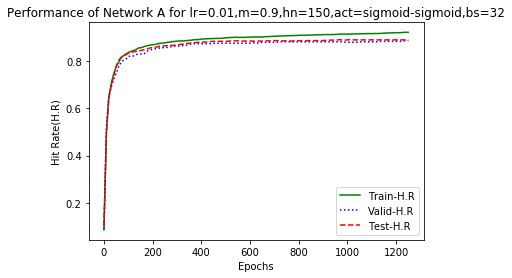

In [151]:
epoch = range(0,1251,10) #
plt.plot(epoch, run_QUES2HW3_thr, color='g',linestyle='-',label='Train-H.R')
plt.plot(epoch, run_QUES2HW3_vhr, color='blue' ,linestyle='dotted',label='Valid-H.R')
plt.plot(epoch, run_QUES2HW3_tehr, color='red',linestyle='dashed',label='Test-H.R')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network A for lr=0.01,m=0.9,hn=150,act=sigmoid-sigmoid,bs=32')
plt.show()

## Metrics and all

In [152]:
def create_conf_matrix(expected, predicted, n_classes):
    m = [[0] * n_classes for i in range(n_classes)]
    for pred, exp in zip(predicted, expected):
        m[int(pred)][int(exp)] += 1
    return m

In [153]:
pred=[]
org=[]
for feat, targ in data_test:
    org.append(targ)
    pred.append(nn.test(feat))
create_conf_matrix(org,pred,10)

[[90, 0, 1, 0, 0, 2, 3, 0, 0, 2],
 [0, 109, 0, 0, 0, 0, 2, 5, 3, 2],
 [0, 1, 93, 0, 1, 0, 1, 2, 0, 0],
 [0, 1, 2, 85, 0, 4, 0, 1, 3, 2],
 [0, 2, 2, 1, 95, 3, 0, 0, 1, 6],
 [0, 0, 0, 3, 0, 72, 0, 0, 1, 0],
 [2, 0, 0, 2, 1, 4, 85, 0, 3, 0],
 [0, 1, 2, 3, 0, 2, 0, 89, 2, 5],
 [0, 0, 6, 4, 1, 4, 1, 1, 85, 2],
 [0, 0, 0, 2, 2, 0, 0, 5, 0, 85]]

In [154]:
pred1=[]
org1=[]
for feat, targ in data_val:
    org1.append(targ)
    pred1.append(nn.test(feat))
create_conf_matrix(org1,pred1,10)

[[45, 0, 2, 0, 0, 1, 1, 0, 0, 1],
 [0, 56, 0, 0, 1, 0, 0, 0, 0, 0],
 [0, 0, 45, 1, 0, 0, 0, 2, 1, 0],
 [0, 0, 0, 44, 0, 5, 0, 0, 1, 1],
 [0, 0, 2, 0, 47, 1, 0, 2, 1, 3],
 [0, 0, 1, 0, 0, 34, 1, 1, 2, 0],
 [1, 1, 0, 0, 1, 1, 43, 0, 0, 0],
 [0, 0, 2, 3, 0, 1, 1, 44, 1, 2],
 [0, 0, 1, 2, 0, 2, 0, 0, 43, 3],
 [0, 0, 0, 0, 1, 1, 0, 2, 0, 42]]

In [155]:
pred1=[]
org1=[]
for feat, targ in data_train:
    org1.append(np.argmax(targ))
    pred1.append(nn.test(feat))
create_conf_matrix(org1,pred1,10)

[[314, 0, 4, 1, 1, 9, 7, 2, 4, 3],
 [0, 391, 1, 1, 1, 2, 2, 5, 6, 4],
 [0, 1, 338, 8, 0, 2, 2, 7, 0, 0],
 [0, 0, 4, 316, 0, 9, 0, 3, 9, 6],
 [0, 0, 5, 1, 330, 3, 2, 8, 9, 9],
 [1, 0, 0, 6, 0, 274, 3, 0, 7, 2],
 [3, 3, 4, 1, 4, 4, 306, 0, 3, 0],
 [0, 1, 10, 10, 1, 3, 1, 326, 4, 8],
 [4, 4, 3, 5, 1, 12, 1, 3, 297, 4],
 [0, 0, 2, 1, 12, 1, 0, 4, 3, 328]]

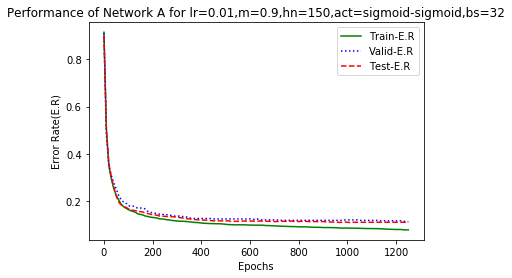

In [156]:
epoch = range(0,1251,10) #
plt.plot(epoch, [1-x for x in run_QUES2HW3_thr], color='g',linestyle='-',label='Train-E.R')
plt.plot(epoch, [1-x for x in run_QUES2HW3_vhr], color='blue' ,linestyle='dotted',label='Valid-E.R')
plt.plot(epoch, [1-x for x in run_QUES2HW3_tehr], color='red',linestyle='dashed',label='Test-E.R')
plt.xlabel('Epochs')
plt.ylabel('Error Rate(E.R)')
plt.legend()
plt.title('Performance of Network A for lr=0.01,m=0.9,hn=150,act=sigmoid-sigmoid,bs=32')
plt.show()

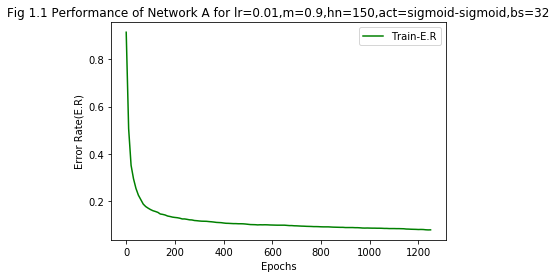

In [157]:
epoch = range(0,1251,10) #
plt.plot(epoch, [1-x for x in run_QUES2HW3_thr], color='g',linestyle='-',label='Train-E.R')
plt.xlabel('Epochs')
plt.ylabel('Error Rate(E.R)')
plt.legend()
plt.title('Fig 1.1 Performance of Network A for lr=0.01,m=0.9,hn=150,act=sigmoid-sigmoid,bs=32')
plt.show()

## Plotting weights between input and hidder layer as feature maps

In [93]:
NET_A=nn.W

In [132]:
NET_A_750=nn.W

In [158]:
NET_A_1250=nn.W

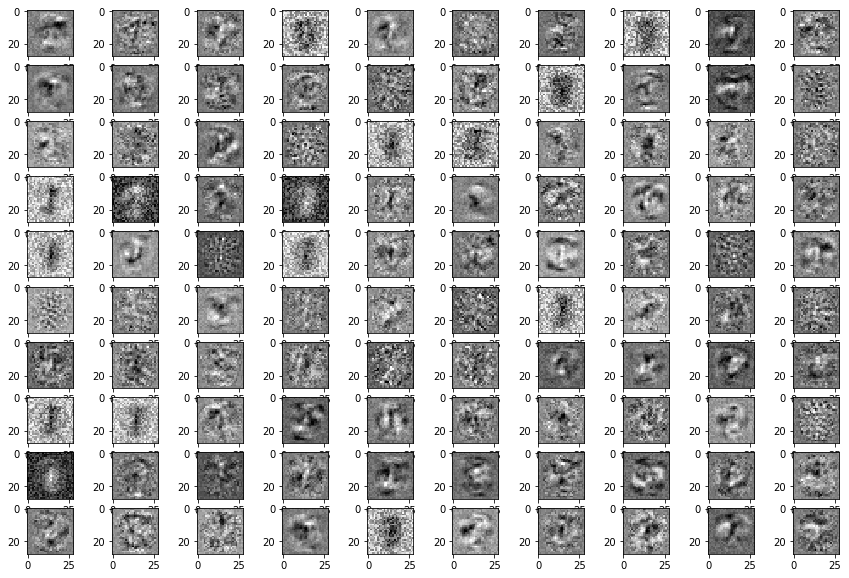

In [159]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(100):
    pixels2 = nn.W[1][i].reshape((28, 28),order='F')
    plt.subplot(10,10,i+1)
    plt.imshow(pixels2, cmap='gray')

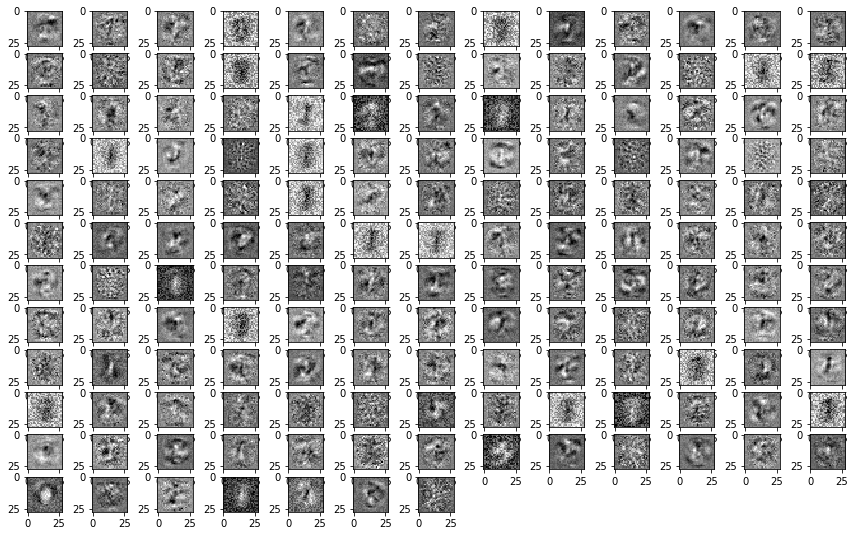

In [160]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(150):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn.W[1][i].reshape((28, 28),order='F')
    plt.subplot(13,13,i+1)
    plt.imshow(pixels2, cmap='gray')

## Getting weights that are obtained  from HW4-PB1 autoencoder network to pass to NETWORK B

In [135]:
with open(os.path.join(os.curdir, 'auto-0.9-0.9sigmoid-sigmoid_PROBLEM1HW4.pkl'),'rb') as f:
    objb1= pickle.load(f)
    
weigToset1 = list(objb1['W'])
biasToset1 = list(objb1['B'])
weigToset1[1]

array([[ 7.91e-323, -1.43e-322,  3.95e-323, ...,  5.93e-323, -1.48e-323,
        -6.92e-323],
       [-1.04e-322, -1.63e-322,  4.94e-324, ..., -5.93e-323,  1.04e-322,
        -1.19e-322],
       [-5.93e-323,  1.48e-323, -9.39e-323, ...,  1.98e-323,  1.48e-323,
         7.41e-323],
       ...,
       [-2.47e-323, -1.38e-322,  7.41e-323, ..., -9.88e-323, -4.45e-323,
        -1.88e-322],
       [ 4.94e-324,  0.00e+000, -2.12e-322, ...,  1.73e-322,  2.47e-323,
        -3.95e-323],
       [ 7.91e-323,  3.46e-323,  8.89e-323, ..., -9.88e-324,  9.88e-323,
        -5.93e-323]])

## Start :Experimenting with different hyper parameters for network B

In [107]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.9
lr = 0.1
itrs = 500
batch_size = 32

nn1 = Model(weigToset1,biasToset1,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
run_QUES1HW4=nn1.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.108 , training hit rate 0.10514285714285715 , testing hit rate 0.117.
For epoch 10, validating hit rate 0.134 , training hit rate 0.14742857142857144 , testing hit rate 0.142.
For epoch 20, validating hit rate 0.21 , training hit rate 0.21971428571428572 , testing hit rate 0.204.
For epoch 30, validating hit rate 0.27 , training hit rate 0.27314285714285713 , testing hit rate 0.268.
For epoch 40, validating hit rate 0.3 , training hit rate 0.31742857142857145 , testing hit rate 0.315.
For epoch 50, validating hit rate 0.348 , training hit rate 0.34885714285714287 , testing hit rate 0.351.
For epoch 60, validating hit rate 0.384 , training hit rate 0.37114285714285716 , testing hit rate 0.372.
For epoch 70, validating hit rate 0.442 , training hit rate 0.43314285714285716 , testing hit rate 0.409.
For epoch 80, validating hit rate 0.488 , training hit rate 0.48542857142857143 , testing hit rate 0.457.
For epoch 90, validating hit rate 0.53 , training h

In [136]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.9
lr = 0.1
itrs = 500
batch_size = 32

nn1 = Model(weigToset1,biasToset1,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
run_QUES1HW4=nn1.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.108 , training hit rate 0.13714285714285715 , testing hit rate 0.123.
For epoch 10, validating hit rate 0.222 , training hit rate 0.22285714285714286 , testing hit rate 0.197.
For epoch 20, validating hit rate 0.272 , training hit rate 0.27485714285714286 , testing hit rate 0.264.
For epoch 30, validating hit rate 0.332 , training hit rate 0.3191428571428571 , testing hit rate 0.308.
For epoch 40, validating hit rate 0.346 , training hit rate 0.35742857142857143 , testing hit rate 0.345.
For epoch 50, validating hit rate 0.378 , training hit rate 0.3954285714285714 , testing hit rate 0.371.
For epoch 60, validating hit rate 0.384 , training hit rate 0.416 , testing hit rate 0.381.
For epoch 70, validating hit rate 0.412 , training hit rate 0.43714285714285717 , testing hit rate 0.408.
For epoch 80, validating hit rate 0.442 , training hit rate 0.48 , testing hit rate 0.451.
For epoch 90, validating hit rate 0.488 , training hit rate 0.5197142857142857

In [137]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.9
lr = 0.1
itrs = 750
batch_size = 32

nn1 = Model(weigToset1,biasToset1,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
run_QUES1HW4=nn1.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.16 , training hit rate 0.12628571428571428 , testing hit rate 0.138.
For epoch 10, validating hit rate 0.166 , training hit rate 0.15542857142857142 , testing hit rate 0.154.
For epoch 20, validating hit rate 0.192 , training hit rate 0.20057142857142857 , testing hit rate 0.173.
For epoch 30, validating hit rate 0.254 , training hit rate 0.26657142857142857 , testing hit rate 0.257.
For epoch 40, validating hit rate 0.31 , training hit rate 0.3377142857142857 , testing hit rate 0.338.
For epoch 50, validating hit rate 0.368 , training hit rate 0.38685714285714284 , testing hit rate 0.391.
For epoch 60, validating hit rate 0.374 , training hit rate 0.41114285714285714 , testing hit rate 0.398.
For epoch 70, validating hit rate 0.398 , training hit rate 0.42457142857142854 , testing hit rate 0.405.
For epoch 80, validating hit rate 0.426 , training hit rate 0.4471428571428571 , testing hit rate 0.433.
For epoch 90, validating hit rate 0.444 , training 

## End :Experimenting with different hyper parameters for network B

## Final RUN for network B with tuned hyper parameters

In [161]:
# After balanced split

#initialize layer sizes as list
layers = [784,150,10]
act_funcs=['NR','sigmoid','sigmoid']
momentum = 0.9
lr = 0.1
itrs = 1250
batch_size = 32

nn1 = Model(weigToset1,biasToset1,layers,act_funcs, lr, momentum, itrs, batch_size,False)
#training neural network
run_QUES1HW4=nn1.train(data_train, data_val, data_test,False)

For epoch 0, validating hit rate 0.04 , training hit rate 0.052571428571428575 , testing hit rate 0.043.
For epoch 10, validating hit rate 0.168 , training hit rate 0.1702857142857143 , testing hit rate 0.186.
For epoch 20, validating hit rate 0.222 , training hit rate 0.22142857142857142 , testing hit rate 0.219.
For epoch 30, validating hit rate 0.268 , training hit rate 0.26257142857142857 , testing hit rate 0.268.
For epoch 40, validating hit rate 0.352 , training hit rate 0.3402857142857143 , testing hit rate 0.343.
For epoch 50, validating hit rate 0.358 , training hit rate 0.38657142857142857 , testing hit rate 0.382.
For epoch 60, validating hit rate 0.366 , training hit rate 0.3994285714285714 , testing hit rate 0.403.
For epoch 70, validating hit rate 0.406 , training hit rate 0.41942857142857143 , testing hit rate 0.426.
For epoch 80, validating hit rate 0.448 , training hit rate 0.448 , testing hit rate 0.442.
For epoch 90, validating hit rate 0.458 , training hit rate 0.47

For epoch 790, validating hit rate 0.822 , training hit rate 0.8614285714285714 , testing hit rate 0.814.
For epoch 800, validating hit rate 0.822 , training hit rate 0.8637142857142858 , testing hit rate 0.813.
For epoch 810, validating hit rate 0.822 , training hit rate 0.8645714285714285 , testing hit rate 0.813.
For epoch 820, validating hit rate 0.822 , training hit rate 0.8648571428571429 , testing hit rate 0.814.
For epoch 830, validating hit rate 0.822 , training hit rate 0.8645714285714285 , testing hit rate 0.815.
For epoch 840, validating hit rate 0.824 , training hit rate 0.8654285714285714 , testing hit rate 0.816.
For epoch 850, validating hit rate 0.824 , training hit rate 0.8671428571428571 , testing hit rate 0.816.
For epoch 860, validating hit rate 0.824 , training hit rate 0.8674285714285714 , testing hit rate 0.817.
For epoch 870, validating hit rate 0.826 , training hit rate 0.8685714285714285 , testing hit rate 0.817.
For epoch 880, validating hit rate 0.826 , tra

In [162]:
run_QUES1HW4_tehr=run_QUES1HW4['tehr']
run_QUES1HW4_thr=run_QUES1HW4['thr']
run_QUES1HW4_vhr=run_QUES1HW4['vhr']

## Plot for hit-rate

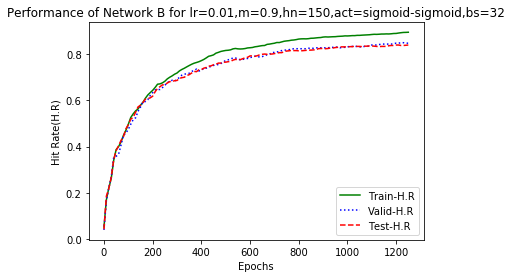

In [163]:
epoch = range(0,1251,10) #
plt.plot(epoch, run_QUES1HW4_thr, color='g',linestyle='-',label='Train-H.R')
plt.plot(epoch, run_QUES1HW4_vhr, color='blue' ,linestyle='dotted',label='Valid-H.R')
plt.plot(epoch, run_QUES1HW4_tehr, color='red',linestyle='dashed',label='Test-H.R')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate(H.R)')
plt.legend()
plt.title('Performance of Network B for lr=0.01,m=0.9,hn=150,act=sigmoid-sigmoid,bs=32')
plt.show()

## Metrics and all

In [164]:
def create_conf_matrix(expected, predicted, n_classes):
    m = [[0] * n_classes for i in range(n_classes)]
    for pred, exp in zip(predicted, expected):
        m[int(pred)][int(exp)] += 1
    return m

In [165]:
pred=[]
org=[]
for feat, targ in data_test:
    org.append(targ)
    pred.append(nn1.test(feat))
create_conf_matrix(org,pred,10)

[[90, 0, 4, 0, 1, 7, 5, 2, 1, 3],
 [0, 104, 0, 0, 0, 0, 1, 5, 2, 2],
 [0, 0, 87, 0, 0, 0, 0, 3, 0, 0],
 [0, 5, 5, 90, 0, 18, 0, 2, 7, 3],
 [0, 2, 2, 1, 95, 3, 3, 3, 5, 16],
 [0, 0, 1, 1, 0, 53, 0, 0, 1, 1],
 [2, 0, 0, 1, 1, 5, 83, 0, 3, 0],
 [0, 0, 2, 4, 0, 0, 0, 87, 1, 5],
 [0, 3, 5, 3, 3, 4, 0, 0, 78, 3],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 71]]

In [166]:
pred1=[]
org1=[]
for feat, targ in data_val:
    org1.append(targ)
    pred1.append(nn1.test(feat))
create_conf_matrix(org1,pred1,10)

[[44, 0, 3, 0, 0, 3, 1, 0, 0, 2],
 [0, 54, 1, 0, 2, 0, 0, 1, 0, 1],
 [0, 0, 39, 0, 0, 0, 0, 1, 1, 0],
 [1, 3, 2, 47, 0, 6, 0, 0, 2, 2],
 [0, 0, 3, 0, 47, 4, 0, 2, 1, 5],
 [0, 0, 0, 0, 0, 28, 1, 0, 2, 3],
 [0, 0, 2, 0, 1, 1, 44, 0, 0, 0],
 [0, 0, 1, 2, 0, 1, 0, 45, 1, 3],
 [1, 0, 2, 1, 0, 2, 0, 1, 42, 3],
 [0, 0, 0, 0, 0, 1, 0, 1, 0, 33]]

In [167]:
pred1=[]
org1=[]
for feat, targ in data_train:
    org1.append(np.argmax(targ))
    pred1.append(nn1.test(feat))
create_conf_matrix(org1,pred1,10)

[[316, 0, 8, 0, 0, 20, 9, 2, 8, 6],
 [0, 395, 0, 0, 1, 6, 2, 5, 3, 5],
 [0, 0, 305, 1, 0, 0, 0, 3, 0, 0],
 [0, 2, 21, 340, 0, 30, 1, 5, 18, 9],
 [0, 1, 13, 2, 342, 16, 4, 10, 8, 39],
 [0, 0, 0, 0, 0, 218, 0, 0, 2, 3],
 [2, 2, 4, 0, 2, 6, 307, 0, 2, 2],
 [1, 0, 12, 5, 0, 7, 0, 328, 3, 13],
 [3, 0, 7, 1, 1, 15, 1, 4, 296, 8],
 [0, 0, 1, 1, 4, 1, 0, 1, 2, 279]]

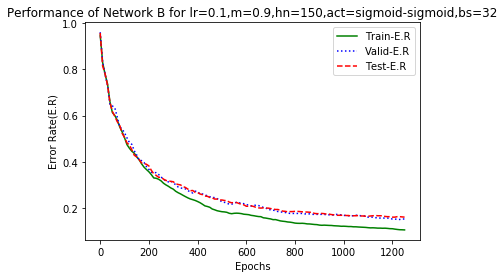

In [174]:
epoch = range(0,1251,10) #
plt.plot(epoch, [1-x for x in run_QUES1HW4_thr], color='g',linestyle='-',label='Train-E.R')
plt.plot(epoch, [1-x for x in run_QUES1HW4_vhr], color='blue' ,linestyle='dotted',label='Valid-E.R')
plt.plot(epoch, [1-x for x in run_QUES1HW4_tehr], color='red',linestyle='dashed',label='Test-E.R')
plt.xlabel('Epochs')
plt.ylabel('Error Rate(E.R)')
plt.legend()
plt.title('Performance of Network B for lr=0.1,m=0.9,hn=150,act=sigmoid-sigmoid,bs=32')
plt.show()

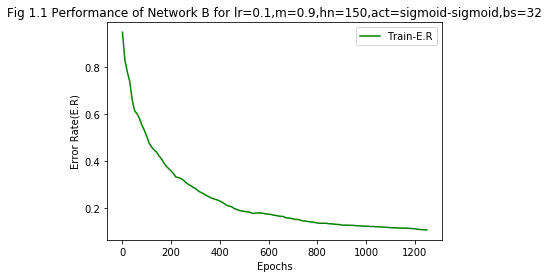

In [175]:
epoch = range(0,1251,10) #
plt.plot(epoch, [1-x for x in run_QUES1HW4_thr], color='g',linestyle='-',label='Train-E.R')
plt.xlabel('Epochs')
plt.ylabel('Error Rate(E.R)')
plt.legend()
plt.title('Fig 1.1 Performance of Network B for lr=0.1,m=0.9,hn=150,act=sigmoid-sigmoid,bs=32')
plt.show()

## Plotting weights between input and hidder layer as feature maps

In [118]:
NET_B=nn1.W

In [145]:
NET_B_FINAL=nn1.W

In [170]:
NET_B_1250=nn1.W

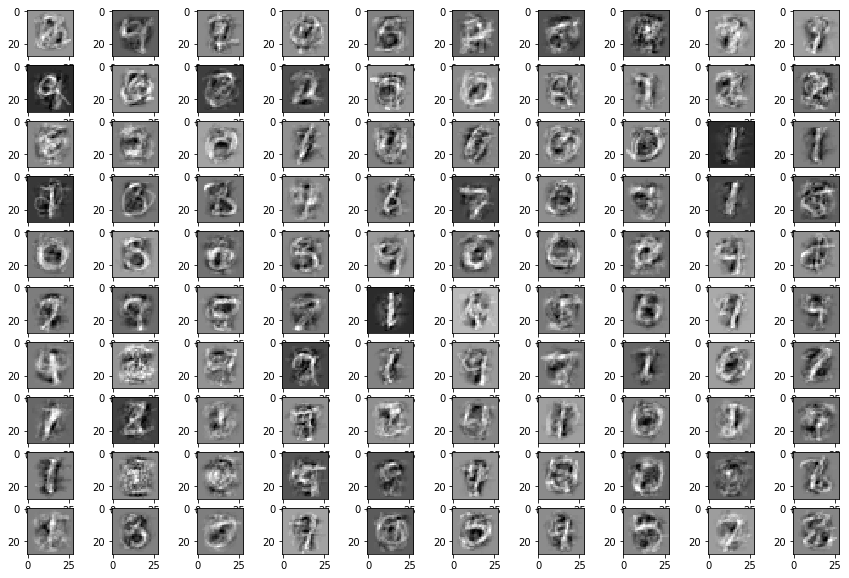

In [171]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(100):
    pixels2 = nn1.W[1][i].reshape((28, 28),order='F')
    plt.subplot(10,10,i+1)
    plt.imshow(pixels2, cmap='gray')

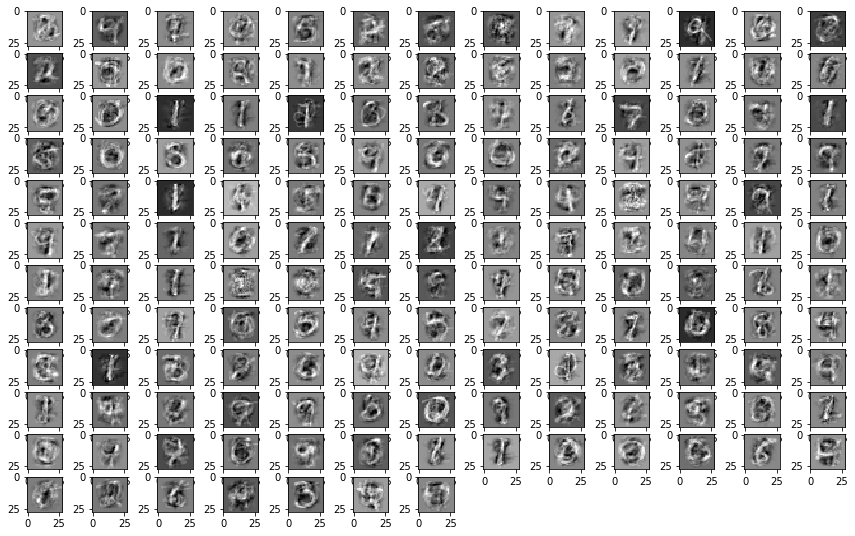

In [172]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 10))

for i in range(150):
    #pixels = arr_x_train[i].reshape((28, 28),order='F')
    pixels2 = nn1.W[1][i].reshape((28, 28),order='F')
    plt.subplot(13,13,i+1)
    plt.imshow(pixels2, cmap='gray')

## END :code required for home work 4 problem -2